In [5]:
import numpy as np
import mccd.mccd_utils as mccd_utils
import mccd.utils as utils
import mccd.auxiliary_fun as mccd_aux
import mccd
from astropy.io import fits

import random

import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

## Define plotting functions

In [14]:
plt.rc('text', usetex=True)
font = {'family' : 'serif',
        'weight' : 'bold',
        'size'   : 20}
mpl.rc('font', **font)

plot_style = {
                'figure.figsize': (6,6),
                'figure.dpi': 100,
                'figure.autolayout':True,
                'lines.linewidth': 4,
                'lines.linestyle': '-',
                'lines.marker': 'o',
                'lines.markersize': 10,
                'legend.fontsize': 20,
                'legend.loc': 'best',
                'axes.titlesize': 24,
                'axes.grid': False,
                'axes.grid.which': 'major',
                'axes.grid.axis': 'both'}
mpl.rcParams.update(plot_style)

def plot_fun(star_img, cmap='gist_stern'):
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    im1 = ax1.imshow(star_img, interpolation='None',cmap=cmap)
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(im1, cax=cax, extend='both')
    cbar.minorticks_on()
    fig.tight_layout()
    ax1.set_xticks([]);ax1.set_yticks([])
    ax1.axis('off')
    plt.show()

loc2glob = mccd.mccd_utils.Loc2Glob()

# Pre-defined colormap
top = mpl.cm.get_cmap('Oranges_r', 128)
bottom = mpl.cm.get_cmap('Blues', 128)
newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))
newcmp = ListedColormap(newcolors, name='OrangeBlue')

# Preprocess the input catalogs

In [6]:
input_folder_path = './../data/sextractor_inputs/'
output_path = './../data/sextractor_preprocessed/'
separator = '-'
CCD_id_filter_list = None
outlier_std_max = 100.
save_masks = True
save_extension = '.fits'
verbose = True

# Train catalog
train_file_pattern = 'sexcat-*-*.fits'
train_save_name = 'train_star_selection'
train_min_n_stars = 20

# Test catalog
test_file_pattern = 'test-star_selection-*-*.fits'
test_save_name = 'test_star_selection'
test_min_n_stars = 5


In [3]:
# Preprocess training dataset
mccd_aux.mccd_preprocessing(input_folder_path=input_folder_path,
                            output_path=output_path,
                            min_n_stars=train_min_n_stars,
                            file_pattern=train_file_pattern,
                            separator=separator,
                            CCD_id_filter_list=CCD_id_filter_list,
                            outlier_std_max=outlier_std_max,
                            save_masks=save_masks,
                            save_name=train_save_name,
                            save_extension=save_extension,
                            verbose=verbose)
    
# Preprocess testing dataset
mccd_aux.mccd_preprocessing(input_folder_path=input_folder_path,
                            output_path=output_path,
                            min_n_stars=test_min_n_stars,
                            file_pattern=test_file_pattern,
                            separator=separator,
                            CCD_id_filter_list=CCD_id_filter_list,
                            outlier_std_max=outlier_std_max,
                            save_masks=save_masks,
                            save_name=test_save_name,
                            save_extension=save_extension,
                            verbose=verbose)



Processing dataset..
Extracting catalog_id 2086592 ..
[]
(0,)
Finished the training dataset processing.
Total stars processed = 6898
Processing dataset..
Extracting catalog_id 2086592 ..
[]
(0,)
Finished the training dataset processing.
Total stars processed = 2000


# Train the MCCD model

### Define the MCCD model parameters

In [7]:
# Parameters

# MCCD instance
n_comp_loc = 12
d_comp_glob = 4
filters = None
ksig_loc = 1.
ksig_glob = 1.

# MCCD fit
psf_size = 6.15
psf_size_type = 'R2'
n_eigenvects = 5
n_iter_rca = 1
nb_iter_glob = 2 
nb_iter_loc = 2
nb_subiter_S_loc = 100
nb_subiter_A_loc = 500
nb_subiter_S_glob = 30
nb_subiter_A_glob = 200
loc_model = 'hybrid'


# Build the paramter dictionaries
mccd_inst_kw = {'n_comp_loc': n_comp_loc, 'd_comp_glob': d_comp_glob,
                'filters': filters,       'ksig_loc': ksig_loc,
                'ksig_glob':ksig_glob}

mccd_fit_kw = {'psf_size': psf_size,                  'psf_size_type':psf_size_type,
              'n_eigenvects': n_eigenvects,          'nb_iter':n_iter_rca,
              'nb_iter_glob':nb_iter_glob,           'nb_iter_loc':nb_iter_loc,
              'nb_subiter_S_loc':nb_subiter_S_loc,   'nb_subiter_A_loc':nb_subiter_A_loc,
              'nb_subiter_S_glob':nb_subiter_S_glob, 'nb_subiter_A_glob':nb_subiter_A_glob,
              'loc_model':loc_model}


### Run  the training

In [8]:
# Parameters
input_path = './../data/sextractor_preprocessed/'
output_dir = './../data/outputs/'
catalog_id = 2086592
verbose = True
input_catalog_path = input_path + train_save_name + separator + '%07d'%catalog_id + save_extension

train_starcat = fits.open(input_catalog_path)[1]


# MCCD model training
mccd_aux.mccd_fit(starcat=train_starcat, mccd_inst_kw=mccd_inst_kw, mccd_fit_kw=mccd_fit_kw,
         output_dir=output_dir, catalog_id=catalog_id, sex_thresh=-1e5, use_SNR_weight=False,
         verbose=verbose)


No SNR weights are being used.
Running basic initialization tasks...
... Done.
Constructing local spatial constraint...


/Users/tliaudat/opt/anaconda3/envs/mccd_env/lib/python3.6/site-packages/mccd-0.0.1-py3.6.egg/mccd/utils.py:523: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


... Done.
Building position polynomials...
... Done.


100% (30 of 30) |########################| Elapsed Time: 0:04:00 Time:  0:04:00
100% (200 of 200) |######################| Elapsed Time: 0:10:59 Time:  0:10:59
100% (30 of 30) |########################| Elapsed Time: 0:04:21 Time:  0:04:21
100% (200 of 200) |######################| Elapsed Time: 0:11:22 Time:  0:11:22
100% (100 of 100) |######################| Elapsed Time: 0:00:28 Time:  0:00:28
100% (500 of 500) |######################| Elapsed Time: 0:00:14 Time:  0:00:14
100% (100 of 100) |######################| Elapsed Time: 0:00:32 Time:  0:00:32
100% (500 of 500) |######################| Elapsed Time: 0:00:17 Time:  0:00:17
100% (100 of 100) |######################| Elapsed Time: 0:00:35 Time:  0:00:35
100% (500 of 500) |######################| Elapsed Time: 0:00:20 Time:  0:00:20
100% (100 of 100) |######################| Elapsed Time: 0:00:39 Time:  0:00:39
100% (500 of 500) |######################| Elapsed Time: 0:00:24 Time:  0:00:24
100% (100 of 100) |#####################

100% (500 of 500) |######################| Elapsed Time: 0:00:21 Time:  0:00:21
100% (100 of 100) |######################| Elapsed Time: 0:00:29 Time:  0:00:29
100% (500 of 500) |######################| Elapsed Time: 0:00:15 Time:  0:00:15
100% (100 of 100) |######################| Elapsed Time: 0:00:29 Time:  0:00:29
100% (500 of 500) |######################| Elapsed Time: 0:00:15 Time:  0:00:15
100% (100 of 100) |######################| Elapsed Time: 0:00:27 Time:  0:00:27
100% (500 of 500) |######################| Elapsed Time: 0:00:13 Time:  0:00:13
100% (100 of 100) |######################| Elapsed Time: 0:00:25 Time:  0:00:25
100% (500 of 500) |######################| Elapsed Time: 0:00:13 Time:  0:00:13
100% (100 of 100) |######################| Elapsed Time: 0:00:30 Time:  0:00:30
100% (500 of 500) |######################| Elapsed Time: 0:00:15 Time:  0:00:15
100% (100 of 100) |######################| Elapsed Time: 0:00:34 Time:  0:00:34
100% (500 of 500) |#####################

KeyboardInterrupt: 

# Validation

In [9]:
# Parameters
output_dir = './../data/mccd_inputs/'
mccd_model_path = output_dir + 'fitted_model2086592.npy'

catalog_id = 2086592
input_catalog_path = input_path + test_save_name + separator + '%07d'%catalog_id + save_extension
test_starcat = fits.open(input_catalog_path)[1]


val_dict = mccd_aux.mccd_validation(mccd_model_path=mccd_model_path, testcat=test_starcat,
                         apply_degradation=True, mccd_debug=False, global_pol_interp=False,
                         sex_thresh=-1e5)



## Calculate the statistics you prefer 

In [10]:
val_dict.keys()

dict_keys(['PSF_VIGNET_LIST', 'PSF_MOM_LIST', 'STAR_MOM_LIST', 'GLOB_POSITION_IMG_LIST', 'VIGNET_LIST', 'MASK_LIST', 'CCD_ID_LIST', 'RA_LIST', 'DEC_LIST'])

In [11]:
test_stars = val_dict['VIGNET_LIST']
matched_PSFs = val_dict['PSF_VIGNET_LIST']

e1_psf = val_dict['PSF_MOM_LIST'][:,0]
e2_psf = val_dict['PSF_MOM_LIST'][:,1]
R2_psf = 2.*val_dict['PSF_MOM_LIST'][:,2]**2

e1_star = val_dict['STAR_MOM_LIST'][:,0]
e2_star = val_dict['STAR_MOM_LIST'][:,1]
R2_star = 2.*val_dict['STAR_MOM_LIST'][:,2]**2


In [12]:
pix_RMSE = np.sqrt(np.mean((test_stars - matched_PSFs)**2))
e1_RMSE = np.sqrt(np.mean((e1_star - e1_psf)**2))
e2_RMSE = np.sqrt(np.mean((e2_star - e2_psf)**2))
R2_RMSE = np.sqrt(np.mean(((R2_star - R2_psf)/R2_star)**2))

print('Pixel RMSE = %.5e'%(pix_RMSE))
print('e1 RMSE = %.5e'%(e1_RMSE))
print('e2 RMSE = %.5e'%(e2_RMSE))
print('R2 RMSE = %.5e'%(R2_RMSE))



Pixel RMSE = 6.40913e-05
e1 RMSE = 5.53192e-03
e2 RMSE = 7.70202e-03
R2 RMSE = 8.69793e-03


### Plot a random test star and its model reconstruction

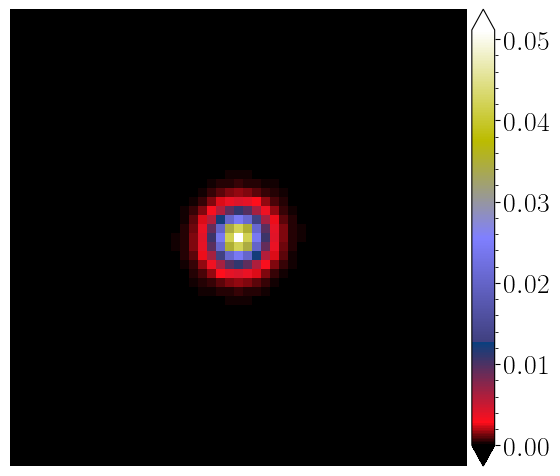

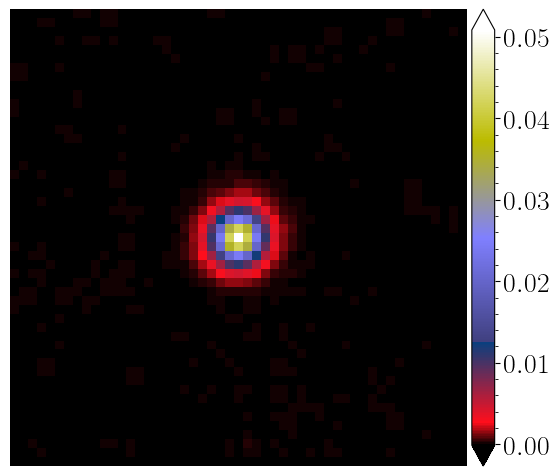

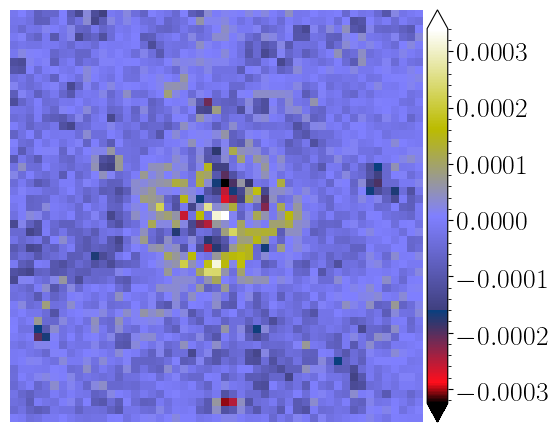

In [15]:
idx = random.randint(0,test_stars.shape[0])

plot_fun(test_stars[idx,:,:])
plot_fun(matched_PSFs[idx,:,:])
plot_fun(test_stars[idx,:,:] - matched_PSFs[idx,:,:])

